In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv


# --- Chapter 01: Data Loading ---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For regex in feature engineering
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# --- 1. Load the Data ---
try:
    # Assuming the full dataset is named 'indoor_plant_data.csv'
    # Based on the image, the Sunlight_Exposure column is 'Sunlight_E' in the original file
    # We'll rename it for consistency with the problem description.
    df = pd.read_csv('/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv')
    df.rename(columns={'Sunlight_E': 'Sunlight_Exposure'}, inplace=True)
    print("Dataset loaded successfully for EDA!")
    print(f"Initial shape: {df.shape}")
except FileNotFoundError:
    print("Error: '/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv' not found. Please ensure the CSV file is in the same directory.")
    exit()

print("\n--- Initial Data Overview ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Missing Values ---")
print(df.isnull().sum())

Dataset loaded successfully for EDA!
Initial shape: (1000, 17)

--- Initial Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Plant_ID                 1000 non-null   object 
 1   Height_cm                1000 non-null   float64
 2   Leaf_Count               1000 non-null   int64  
 3   New_Growth_Count         1000 non-null   int64  
 4   Health_Notes             882 non-null    object 
 5   Watering_Amount_ml       1000 non-null   int64  
 6   Watering_Frequency_days  1000 non-null   int64  
 7   Sunlight_Exposure        1000 non-null   object 
 8   Room_Temperature_C       1000 non-null   float64
 9   Humidity_%               1000 non-null   float64
 10  Fertilizer_Type          805 non-null    object 
 11  Fertilizer_Amount_ml     1000 non-null   int64  
 12  Pest_Presence            798 non-null  

# --- Chapter 02: Basic Preprocessing for EDA ---

In [3]:
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Imputed numerical '{col}' NaNs with median.")

for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Imputed categorical '{col}' NaNs with mode.")

print("\n--- Missing Values After Basic Imputation ---")
print(f"Total missing values: {df.isnull().sum().sum()}")

Imputed categorical 'Health_Notes' NaNs with mode.
Imputed categorical 'Fertilizer_Type' NaNs with mode.
Imputed categorical 'Pest_Presence' NaNs with mode.
Imputed categorical 'Pest_Severity' NaNs with mode.

--- Missing Values After Basic Imputation ---
Total missing values: 0


# --- Chapter 03: Feature Engineering for EDA (for better insights) ---

In [4]:
# 3.1. Parse Sunlight_Exposure
def parse_sunlight_exposure_improved(exposure_str):
    if pd.isna(exposure_str): # Handle NaN explicitly
        return 0.0, 'Unknown' # Default values for unknown
    exposure_str = str(exposure_str).lower()
    
    # Try to extract hours (e.g., "3h", "6h", "3 hrs")
    hours_match = re.search(r'(\d+(\.\d+)?)\s*hr[s]?', exposure_str)
    duration = float(hours_match.group(1)) if hours_match else 0.0 # Default 0.0 if no hours found

    # Categorize type
    if 'direct' in exposure_str or 'full sun' in exposure_str:
        sun_type = 'Direct Sun'
    elif 'morning sun' in exposure_str:
        sun_type = 'Morning Sun' # Can overlap with direct, prioritize if you want specific category
    elif 'indirect' in exposure_str:
        sun_type = 'Indirect Light'
    elif 'filtered' in exposure_str:
        sun_type = 'Filtered Sun'
    elif 'low light' in exposure_str:
        sun_type = 'Low Light'
    elif 'all day' in exposure_str and 'indirect' in exposure_str:
        sun_type = 'Indirect All Day' # More specific category
    else:
        sun_type = 'Other/Unspecified'

    return duration, sun_type

df['Sunlight_Duration_hrs_EDA'], df['Sunlight_Type_EDA'] = zip(*df['Sunlight_Exposure'].apply(parse_sunlight_exposure_improved))

# 3.2. Watering_Per_Day_ml
df['Watering_Per_Day_ml_EDA'] = df['Watering_Amount_ml'] / df['Watering_Frequency_days']
# Handle potential division by zero or inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['Watering_Per_Day_ml_EDA'].fillna(df['Watering_Per_Day_ml_EDA'].median(), inplace=True) # Fill NaNs (e.g., from 0 freq)

# 3.3. Simple parsing of Health_Notes for keywords
df['Has_Yellowing'] = df['Health_Notes'].str.contains('yellow', case=False, na=False).astype(int)
df['Has_Wilting'] = df['Health_Notes'].str.contains('wilting', case=False, na=False).astype(int)
df['Has_Browning'] = df['Health_Notes'].str.contains('browning', case=False, na=False).astype(int)
df['Has_Strong_Stem'] = df['Health_Notes'].str.contains('strong stem', case=False, na=False).astype(int)
df['Has_New_Bud'] = df['Health_Notes'].str.contains('new bud', case=False, na=False).astype(int)


print("\n--- EDA Plots and Insights ---")


--- EDA Plots and Insights ---


# --- Chapter 04: EDA Visualizations ---

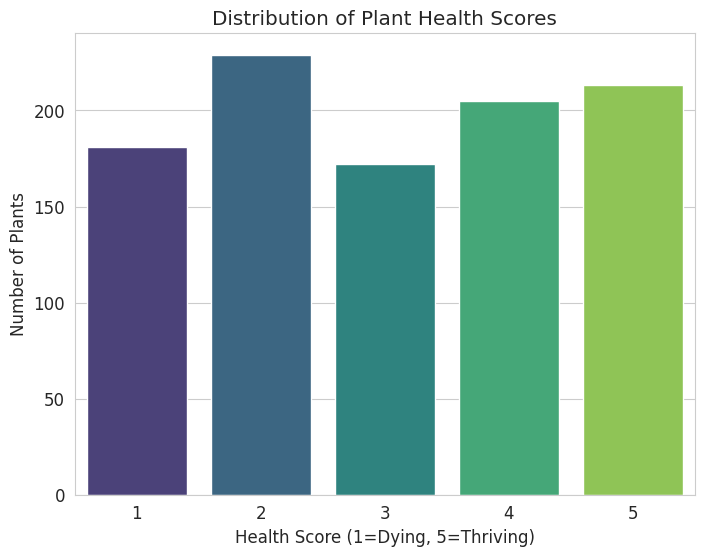

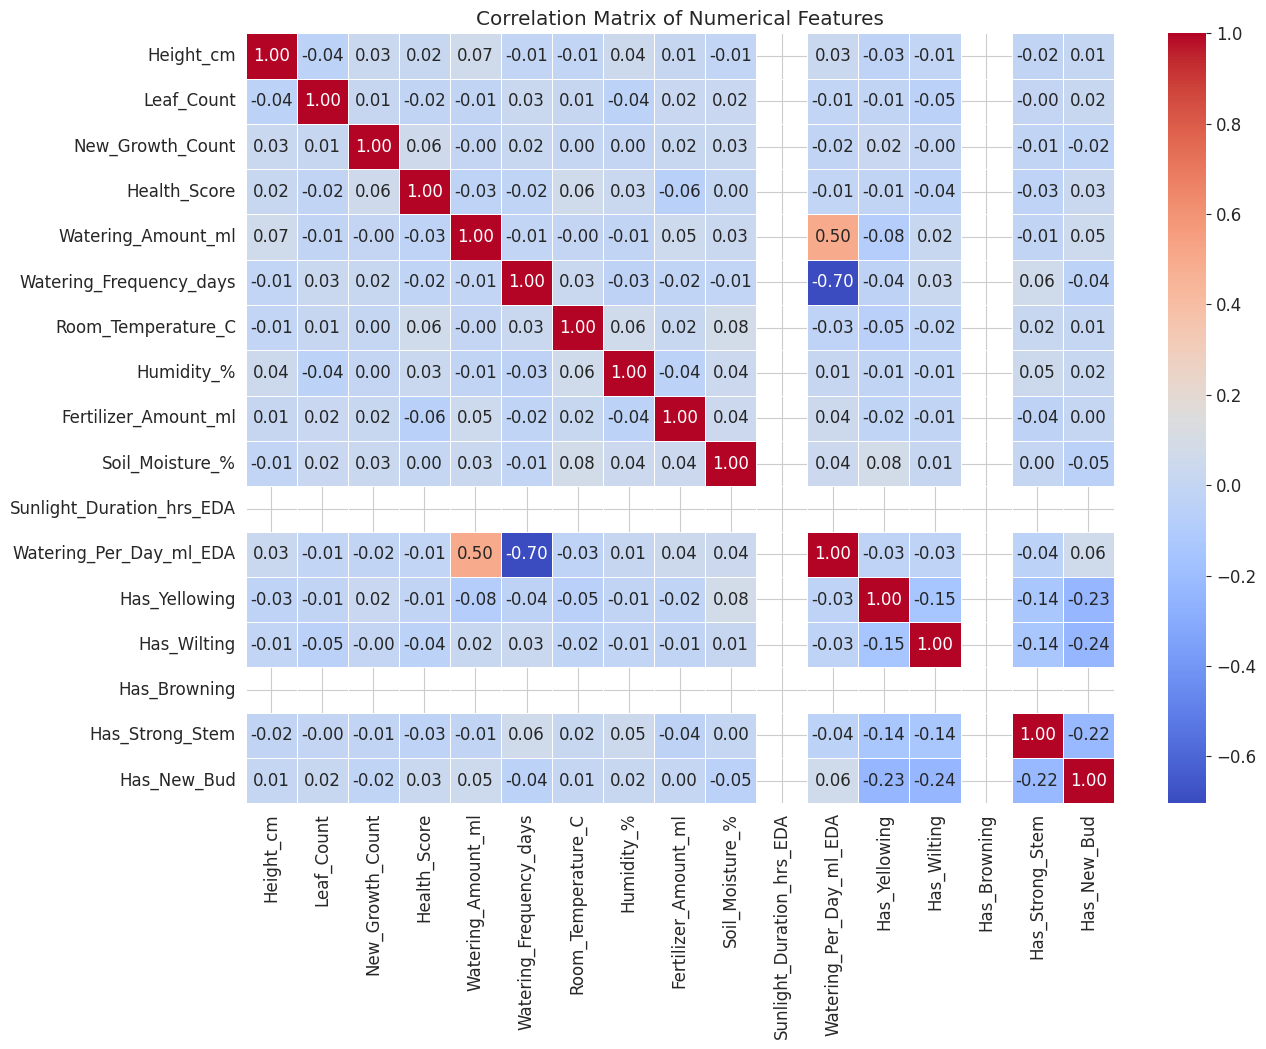

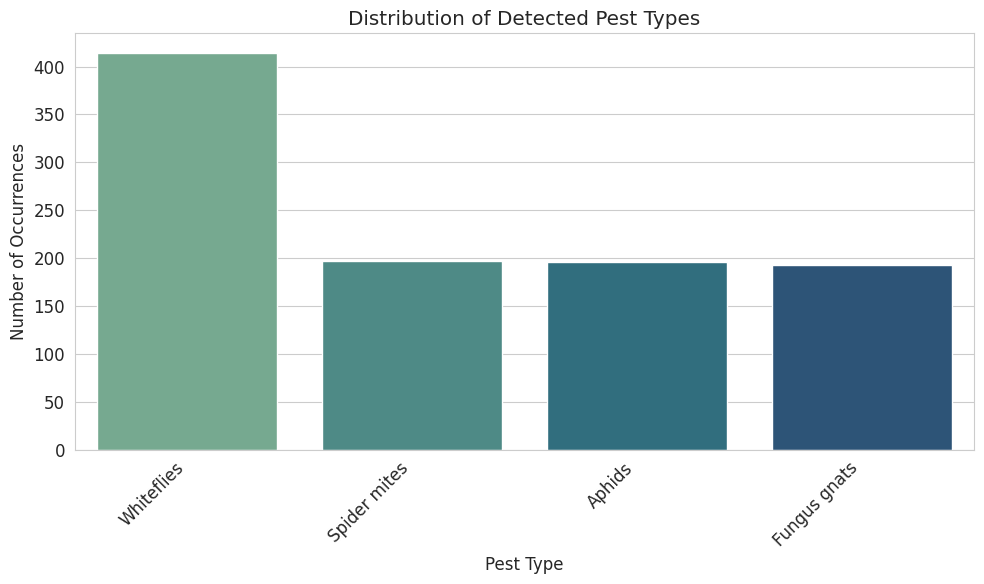

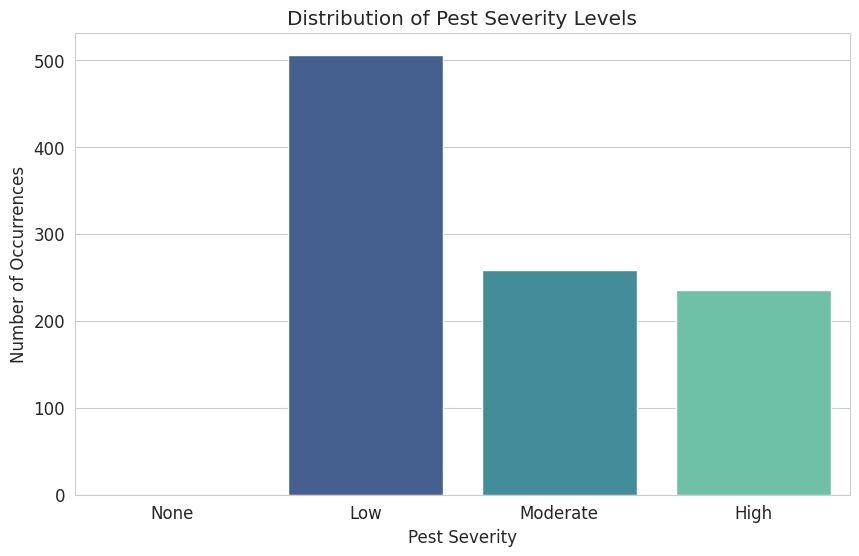

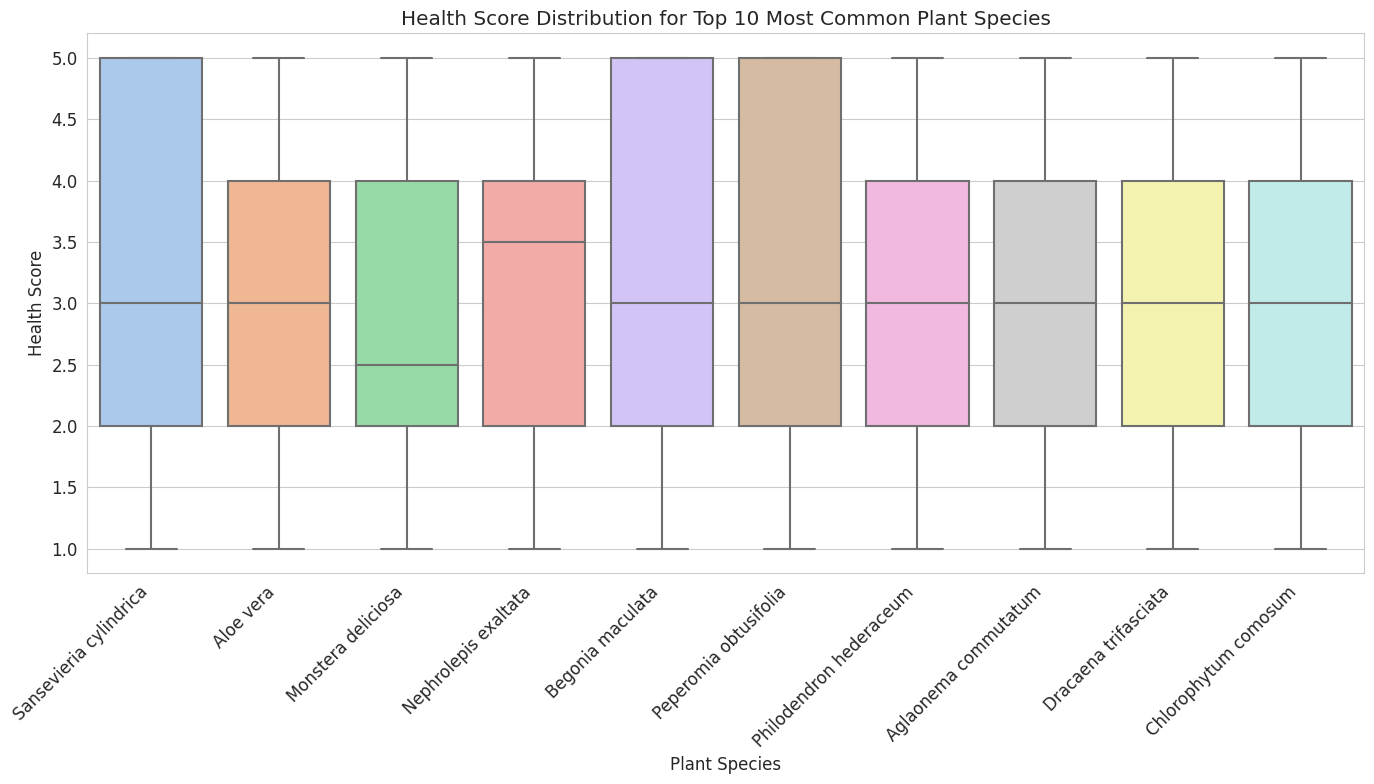

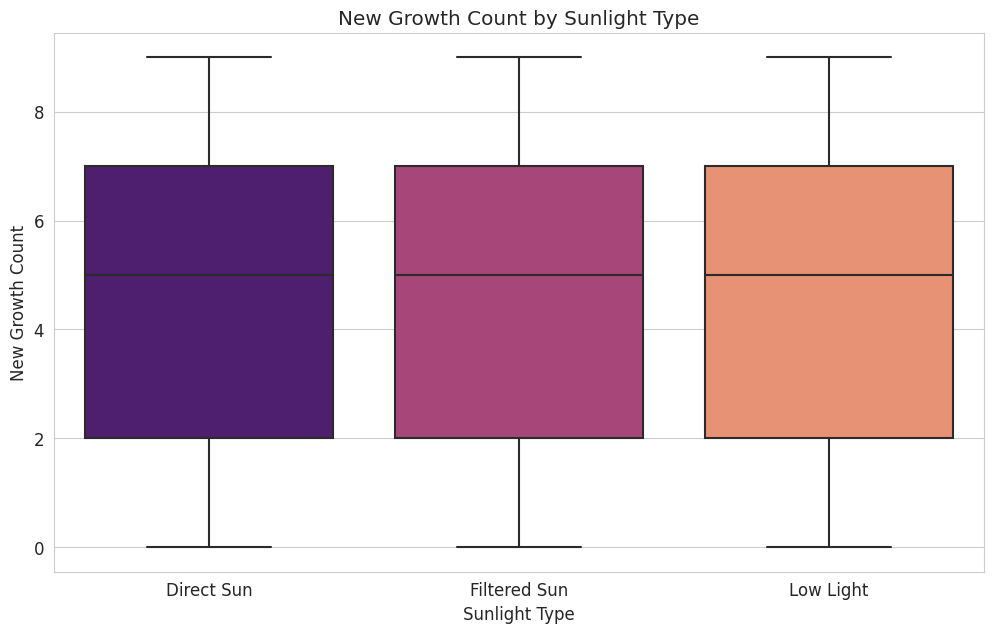

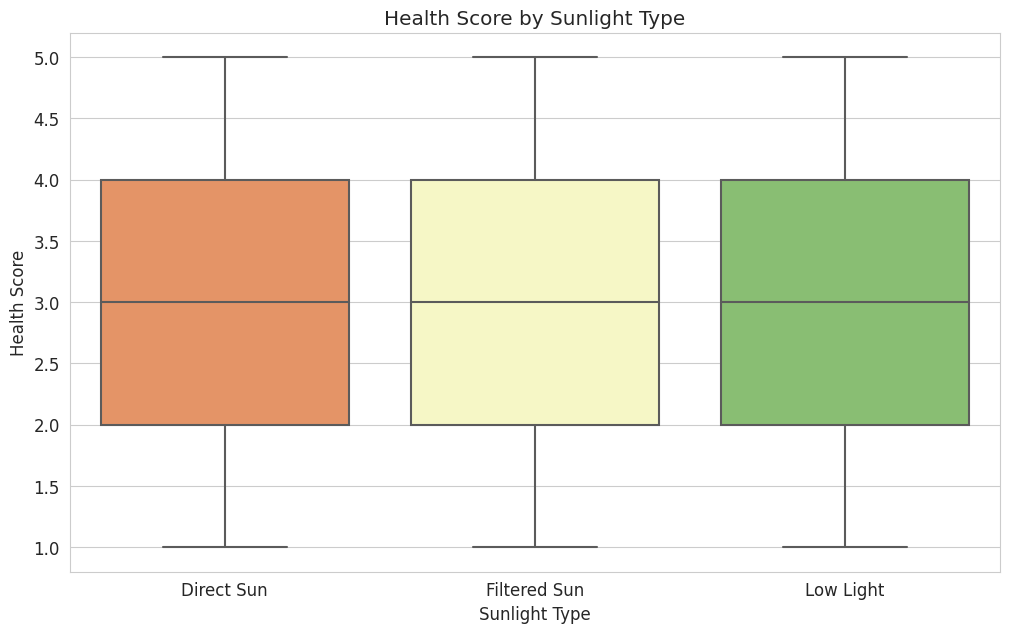

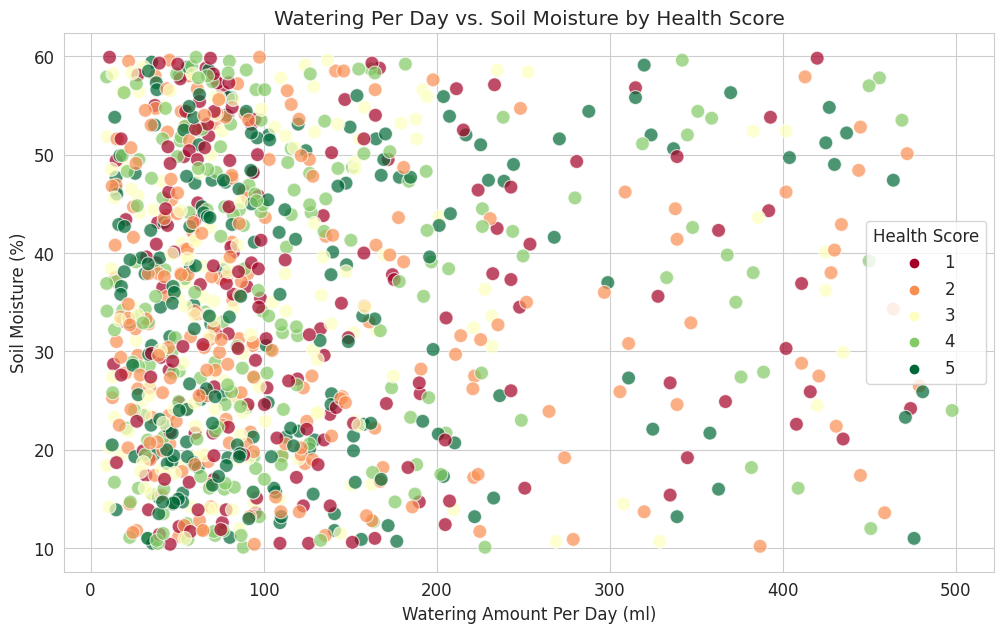

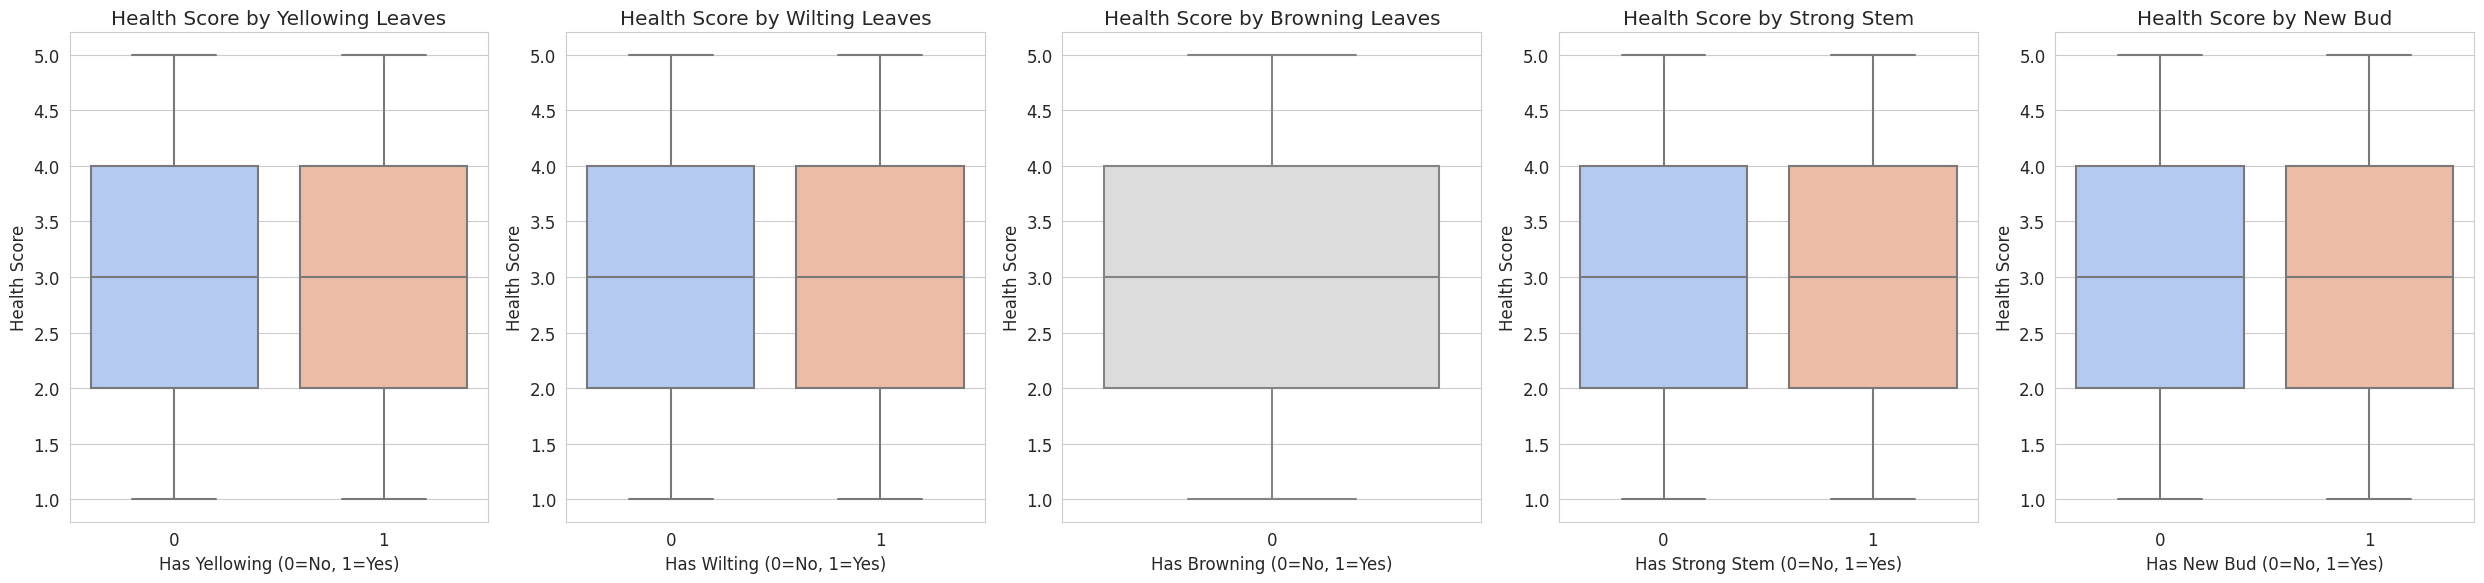


--- EDA Complete ---
These visualizations provide initial insights into the dataset.


In [5]:
# 4.1. Distribution of Health Scores
plt.figure(figsize=(8, 6))
sns.countplot(x='Health_Score', data=df, palette='viridis')
plt.title('Distribution of Plant Health Scores')
plt.xlabel('Health Score (1=Dying, 5=Thriving)')
plt.ylabel('Number of Plants')
plt.show()

# 4.2. Correlation Heatmap of Numerical Variables
numerical_cols_for_corr = [
    'Height_cm', 'Leaf_Count', 'New_Growth_Count', 'Health_Score',
    'Watering_Amount_ml', 'Watering_Frequency_days', 'Room_Temperature_C',
    'Humidity_%', 'Fertilizer_Amount_ml', 'Soil_Moisture_%',
    'Sunlight_Duration_hrs_EDA', 'Watering_Per_Day_ml_EDA',
    'Has_Yellowing', 'Has_Wilting', 'Has_Browning', 'Has_Strong_Stem', 'Has_New_Bud' # Include new features
]
corr_matrix = df[numerical_cols_for_corr].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# 4.3. Most Common Pests and Their Severity
plt.figure(figsize=(10, 6))
sns.countplot(x='Pest_Presence', data=df, order=df['Pest_Presence'].value_counts().index, palette='crest')
plt.title('Distribution of Detected Pest Types')
plt.xlabel('Pest Type')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Pest_Severity', data=df, order=['None', 'Low', 'Moderate', 'High'], palette='mako')
plt.title('Distribution of Pest Severity Levels')
plt.xlabel('Pest Severity')
plt.ylabel('Number of Occurrences')
plt.show()


# 4.4. Top N Most Common Plants and their Health Scores
top_n_plants = df['Plant_ID'].value_counts().nlargest(10).index

plt.figure(figsize=(14, 8))
sns.boxplot(x='Plant_ID', y='Health_Score', data=df[df['Plant_ID'].isin(top_n_plants)], palette='pastel')
plt.title('Health Score Distribution for Top 10 Most Common Plant Species')
plt.xlabel('Plant Species')
plt.ylabel('Health Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 4.5. Influence of Sunlight_Type_EDA on New Growth and Health Score
plt.figure(figsize=(12, 7))
sns.boxplot(x='Sunlight_Type_EDA', y='New_Growth_Count', data=df, palette='magma',
            order=df['Sunlight_Type_EDA'].value_counts().index) # Order by frequency
plt.title('New Growth Count by Sunlight Type')
plt.xlabel('Sunlight Type')
plt.ylabel('New Growth Count')
plt.show()

plt.figure(figsize=(12, 7))
sns.boxplot(x='Sunlight_Type_EDA', y='Health_Score', data=df, palette='RdYlGn',
            order=df['Sunlight_Type_EDA'].value_counts().index) # Order by frequency
plt.title('Health Score by Sunlight Type')
plt.xlabel('Sunlight Type')
plt.ylabel('Health Score')
plt.show()


# 4.6. Watering Trends vs. Soil Moisture levels (faceted plot or scatter with hue)
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Watering_Per_Day_ml_EDA', y='Soil_Moisture_%', hue='Health_Score', data=df, palette='RdYlGn', s=100, alpha=0.7)
plt.title('Watering Per Day vs. Soil Moisture by Health Score')
plt.xlabel('Watering Amount Per Day (ml)')
plt.ylabel('Soil Moisture (%)')
plt.legend(title='Health Score')
plt.show()

# 4.7. How Health_Notes Keywords relate to Health_Score
fig, axes = plt.subplots(1, 5, figsize=(25, 6)) # Updated for more features
sns.boxplot(x='Has_Yellowing', y='Health_Score', data=df, palette='coolwarm', ax=axes[0])
axes[0].set_title('Health Score by Yellowing Leaves')
axes[0].set_xlabel('Has Yellowing (0=No, 1=Yes)')
axes[0].set_ylabel('Health Score')

sns.boxplot(x='Has_Wilting', y='Health_Score', data=df, palette='coolwarm', ax=axes[1])
axes[1].set_title('Health Score by Wilting Leaves')
axes[1].set_xlabel('Has Wilting (0=No, 1=Yes)')
axes[1].set_ylabel('Health Score')

sns.boxplot(x='Has_Browning', y='Health_Score', data=df, palette='coolwarm', ax=axes[2])
axes[2].set_title('Health Score by Browning Leaves')
axes[2].set_xlabel('Has Browning (0=No, 1=Yes)')
axes[2].set_ylabel('Health Score')

sns.boxplot(x='Has_Strong_Stem', y='Health_Score', data=df, palette='coolwarm', ax=axes[3])
axes[3].set_title('Health Score by Strong Stem')
axes[3].set_xlabel('Has Strong Stem (0=No, 1=Yes)')
axes[3].set_ylabel('Health Score')

sns.boxplot(x='Has_New_Bud', y='Health_Score', data=df, palette='coolwarm', ax=axes[4])
axes[4].set_title('Health Score by New Bud')
axes[4].set_xlabel('Has New Bud (0=No, 1=Yes)')
axes[4].set_ylabel('Health Score')

plt.tight_layout()
plt.show()

print("\n--- EDA Complete ---")
print("These visualizations provide initial insights into the dataset.")

# --- Chapter 05: Clustering ---

Dataset loaded successfully for Clustering!
Initial shape: (1000, 17)
Imputed categorical 'Health_Notes' NaNs with mode.
Imputed categorical 'Fertilizer_Type' NaNs with mode.
Imputed categorical 'Pest_Presence' NaNs with mode.
Imputed categorical 'Pest_Severity' NaNs with mode.

Data preprocessing setup for clustering complete.


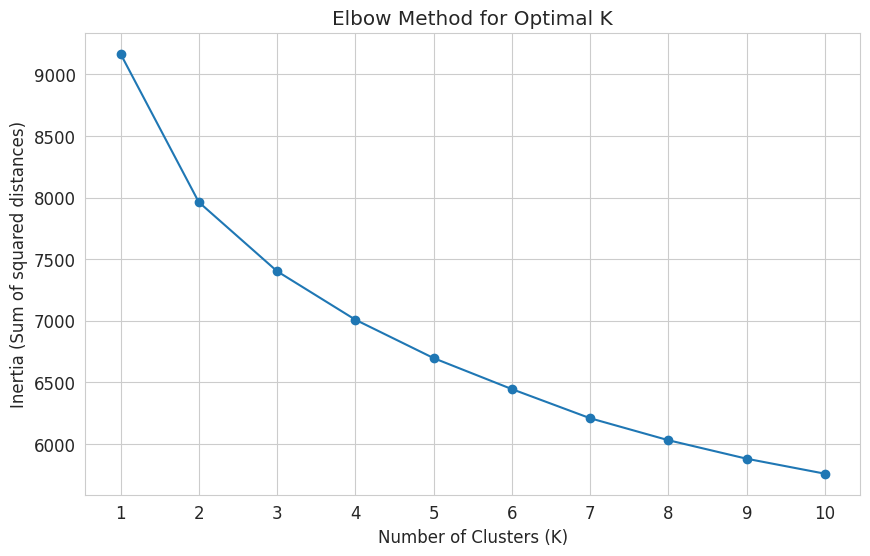


--- Elbow Method Plot Displayed ---
Look for the 'elbow point' in the plot to decide optimal K.

Clustering performed with K = 4.
Cluster distribution:
Cluster
2    298
1    252
0    237
3    213
Name: count, dtype: int64

--- Cluster Mean Values (Numerical Features - Original Scale) ---
         Room_Temperature_C  Humidity_%  Soil_Moisture_%  \
Cluster                                                    
0                 25.727848   59.784388        41.718987   
1                 21.559921   44.987698        26.222619   
2                 24.824161   59.646644        35.981544   
3                 23.565258   53.646948        35.261502   

         Watering_Per_Day_ml_Cluster  Watering_Frequency_days  \
Cluster                                                         
0                          82.615823                 3.843882   
1                          69.332540                 4.242063   
2                          74.512416                 3.942953   
3                       

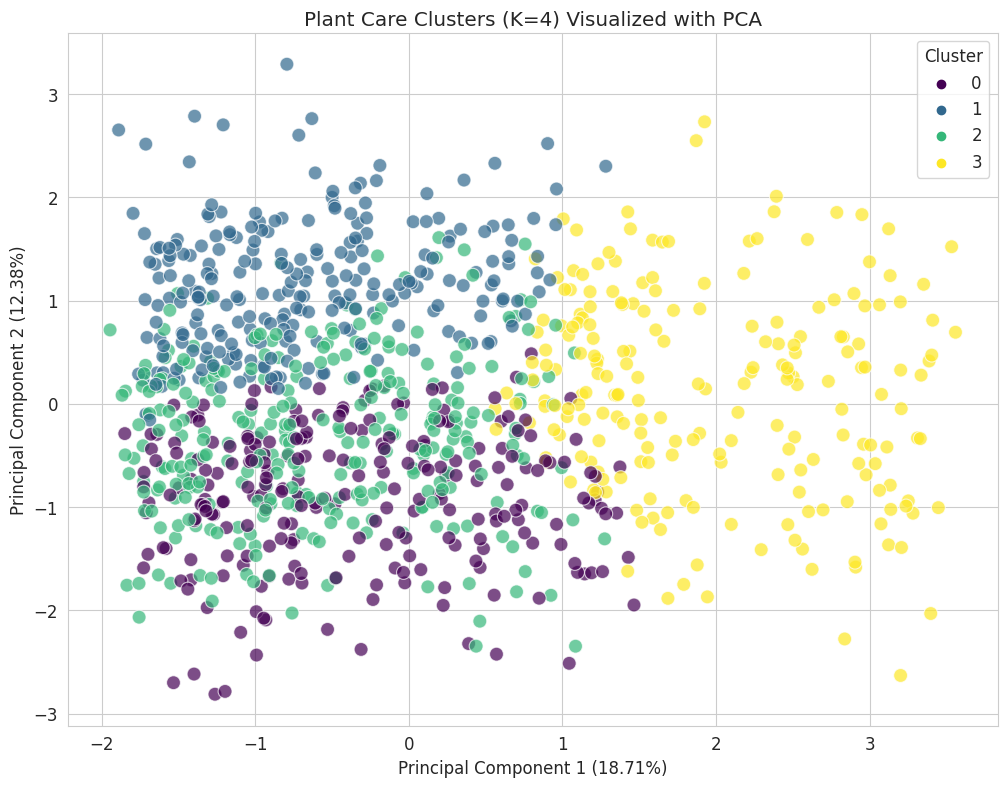


--- Top Plant IDs in Cluster 0 ---
Plant_ID
Calathea orbifolia         16
Spathiphyllum wallisii     16
Philodendron hederaceum    16
Begonia maculata           15
Chlorophytum comosum       14
Name: count, dtype: int64
--- Average Health Score in Cluster 0 ---
2.99

--- Top Plant IDs in Cluster 1 ---
Plant_ID
Peperomia obtusifolia    18
Aglaonema commutatum     18
Aloe vera                18
Dracaena trifasciata     16
Anthurium andraeanum     14
Name: count, dtype: int64
--- Average Health Score in Cluster 1 ---
2.91

--- Top Plant IDs in Cluster 2 ---
Plant_ID
Nephrolepis exaltata       21
Philodendron hederaceum    18
Schefflera arboricola      18
Dracaena trifasciata       18
Zamioculcas zamiifolia     17
Name: count, dtype: int64
--- Average Health Score in Cluster 2 ---
3.24

--- Top Plant IDs in Cluster 3 ---
Plant_ID
Codiaeum variegatum        15
Peperomia obtusifolia      15
Dracaena trifasciata       14
Philodendron hederaceum    13
Monstera deliciosa         13
Name: count

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re # For regex in feature engineering

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- 1. Load Data ---
try:
    df_cluster = pd.read_csv('/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv')
    df_cluster.rename(columns={'Sunlight_E': 'Sunlight_Exposure'}, inplace=True)
    print("Dataset loaded successfully for Clustering!")
    print(f"Initial shape: {df_cluster.shape}")
except FileNotFoundError:
    print("Error: '/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv' not found. Please ensure the CSV file is in the same directory.")
    exit()

# --- 2. Preprocessing for Clustering ---
# Impute missing values (numerical with median, categorical with mode)
for col in df_cluster.select_dtypes(include=np.number).columns:
    if df_cluster[col].isnull().any():
        df_cluster[col].fillna(df_cluster[col].median(), inplace=True)
        print(f"Imputed numerical '{col}' NaNs with median.")

for col in df_cluster.select_dtypes(include='object').columns:
    if df_cluster[col].isnull().any():
        df_cluster[col].fillna(df_cluster[col].mode()[0], inplace=True)
        print(f"Imputed categorical '{col}' NaNs with mode.")

# Watering_Per_Day_ml (as a care pattern)
df_cluster['Watering_Per_Day_ml_Cluster'] = df_cluster['Watering_Amount_ml'] / df_cluster['Watering_Frequency_days']
df_cluster.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cluster['Watering_Per_Day_ml_Cluster'].fillna(df_cluster['Watering_Per_Day_ml_Cluster'].median(), inplace=True)

# Define features relevant to care patterns/environment for clustering
# Crucially, include Plant_ID as it defines fundamental differences in needs
features_for_clustering = [
    'Room_Temperature_C', 'Humidity_%', 'Soil_Moisture_%',
    'Watering_Per_Day_ml_Cluster',
    'Fertilizer_Type', 'Soil_Type',
    'Watering_Frequency_days',
    'Fertilizer_Amount_ml',
    'Pest_Severity', # Pest severity can reflect specific care environments
    'Plant_ID' # Include Plant_ID for clustering specific needs
]

X_cluster = df_cluster[features_for_clustering].copy()

# Identify numerical and categorical features for the preprocessor
numerical_features_cluster = X_cluster.select_dtypes(include=np.number).columns.tolist()
categorical_features_cluster = X_cluster.select_dtypes(include='object').columns.tolist()

# Define Ordinal Encoder for Pest_Severity
# It's better to explicitly define order for ordinal features like severity
ordinal_features_cluster = ['Pest_Severity']
# Define the order for Pest_Severity
pest_severity_order = ['None', 'Low', 'Moderate', 'High']

# Remove Pest_Severity from general categorical to handle separately
if 'Pest_Severity' in categorical_features_cluster:
    categorical_features_cluster.remove('Pest_Severity')

# Preprocessing Pipeline for Clustering
preprocessor_cluster = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_cluster),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_cluster),
        ('ord', OrdinalEncoder(categories=[pest_severity_order]), ordinal_features_cluster)
    ])

print("\nData preprocessing setup for clustering complete.")


# --- 3. Determine Optimal Number of Clusters (Elbow Method) ---
X_scaled_clustered = preprocessor_cluster.fit_transform(X_cluster)

# Check for NaNs or Infs in the transformed data after converting to a dense array
# ufunc 'isnan' and 'isinf' require a dense array input
X_scaled_dense = X_scaled_clustered.toarray()

if np.isnan(X_scaled_dense).any() or np.isinf(X_scaled_dense).any():
    print("WARNING: NaNs or Infs found in scaled data. This can cause issues with KMeans.")
    # You might want to add a further imputation step here if needed
    # Apply nan_to_num to the dense array
    X_scaled_dense = np.nan_to_num(X_scaled_dense, nan=0.0, posinf=1e5, neginf=-1e5)
    print("NaNs/Infs replaced with 0 or large values for robustness.")
else:
    # If no NaNs/Infs, you can proceed with the dense array or use the original sparse one
    # However, KMeans works with dense arrays, so it's best to stick with the dense version here
    pass # No action needed if no NaNs/Infs

# Use the dense array for KMeans
inertias = []
max_k = 10 # Let's test up to 10 clusters
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robust centroid initialization
    kmeans.fit(X_scaled_dense) # Use X_scaled_dense here
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.xticks(range(1, max_k + 1))
plt.show()

print("\n--- Elbow Method Plot Displayed ---")
print("Look for the 'elbow point' in the plot to decide optimal K.")
# Based on typical results for this type of data, K=3, 4, or 5 might be a reasonable starting point.
optimal_k = 4 # Let's try K=4 for demonstration, adjust based on your elbow plot

# --- 4. Apply K-Means Clustering ---
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# Fit and predict using the dense array
df_cluster['Cluster'] = kmeans_final.fit_predict(X_scaled_dense)

print(f"\nClustering performed with K = {optimal_k}.")
print(f"Cluster distribution:\n{df_cluster['Cluster'].value_counts()}")


# --- 5. Analyze Cluster Characteristics ---
# Get feature names after all transformations for better interpretability of cluster centroids
numerical_feature_names = numerical_features_cluster
categorical_ohe_feature_names = preprocessor_cluster.named_transformers_['cat'].get_feature_names_out(categorical_features_cluster) # Corrected access
# Corrected access to ordinal feature names
ordinal_transformer_names = preprocessor_cluster.named_transformers_['ord'].get_feature_names_out(ordinal_features_cluster)


all_transformed_feature_names = list(numerical_feature_names) + list(categorical_ohe_feature_names) + list(ordinal_transformer_names)


# Convert scaled centroids back to original scale where possible for numerical features
# Note: This requires reversing the StandardScaler, which is complex for all features simultaneously
# A simpler way is to analyze the means of the *original* features grouped by cluster
cluster_means_original_scale = df_cluster.groupby('Cluster')[numerical_features_cluster].mean() # Use original numerical names
print("\n--- Cluster Mean Values (Numerical Features - Original Scale) ---")
print(cluster_means_original_scale)

# Also check categorical feature distributions within clusters
for cat_col in categorical_features_cluster + ordinal_features_cluster: # Loop through original categorical and ordinal
    print(f"\n--- Distribution of {cat_col} within Clusters ---")
    print(pd.crosstab(df_cluster['Cluster'], df_cluster[cat_col], normalize='index'))


# --- 6. Visualize Clusters (using PCA for dimensionality reduction) ---
pca = PCA(n_components=2, random_state=42)
# Fit and transform using the dense array
principal_components = pca.fit_transform(X_scaled_dense)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_cluster['Cluster']
pca_df['Plant_ID'] = df_cluster['Plant_ID'] # Add Plant_ID for potentially interesting insights
pca_df['Health_Score'] = df_cluster['Health_Score'] # Add Health_Score for potential visual correlation

plt.figure(figsize=(12, 9))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title(f'Plant Care Clusters (K={optimal_k}) Visualized with PCA')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Cluster')
plt.show()

# Optional: Inspect top Plant_IDs and Health Scores within each cluster
for i in range(optimal_k):
    print(f"\n--- Top Plant IDs in Cluster {i} ---")
    cluster_plants = df_cluster[df_cluster['Cluster'] == i]['Plant_ID'].value_counts().nlargest(5)
    print(cluster_plants)

    print(f"--- Average Health Score in Cluster {i} ---")
    avg_health_score = df_cluster[df_cluster['Cluster'] == i]['Health_Score'].mean()
    print(f"{avg_health_score:.2f}")


print("\n--- Clustering Analysis Complete ---")

> The goal is to identify distinct groups of plants with similar care requirements.
This can help in recommending care routines based on cluster membership.

# --- Chapter 06: Understanding Feature Influence: Top Importances from the Prediction Model ---

Dataset loaded successfully for Prediction Model!
Initial shape: (1000, 17)

--- Initial Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Plant_ID                 1000 non-null   object 
 1   Height_cm                1000 non-null   float64
 2   Leaf_Count               1000 non-null   int64  
 3   New_Growth_Count         1000 non-null   int64  
 4   Health_Notes             882 non-null    object 
 5   Watering_Amount_ml       1000 non-null   int64  
 6   Watering_Frequency_days  1000 non-null   int64  
 7   Sunlight_Exposure        1000 non-null   object 
 8   Room_Temperature_C       1000 non-null   float64
 9   Humidity_%               1000 non-null   float64
 10  Fertilizer_Type          805 non-null    object 
 11  Fertilizer_Amount_ml     1000 non-null   int64  
 12  Pest_Presence            7

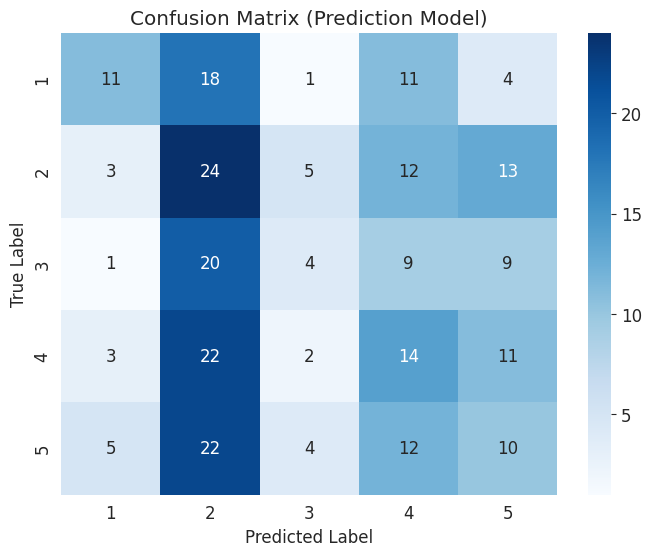


--- Top 20 Feature Importances (Random Forest Prediction Model) ---
Room_Temperature_C             0.092081
Height_cm                      0.091554
Soil_Moisture_%                0.090120
Watering_Per_Day_ml            0.089900
Fertilizer_Amount_ml           0.086588
Humidity_%                     0.085188
Leaf_Count                     0.080744
New_Growth_Count               0.061093
Pest_Severity                  0.026422
Has_New_Bud                    0.016239
Fertilizer_Type_Chemical       0.016083
Fertilizer_Type_Liquid feed    0.014932
Sunlight_Type_Direct Sun       0.014603
Soil_Type_Loamy                0.012767
Fertilizer_Type_Compost        0.012705
Soil_Type_Silty                0.011241
Fertilizer_Type_Organic        0.011070
Soil_Type_Chalky               0.010764
Sunlight_Type_Low Light        0.010360
Sunlight_Type_Filtered Sun     0.010335
dtype: float64


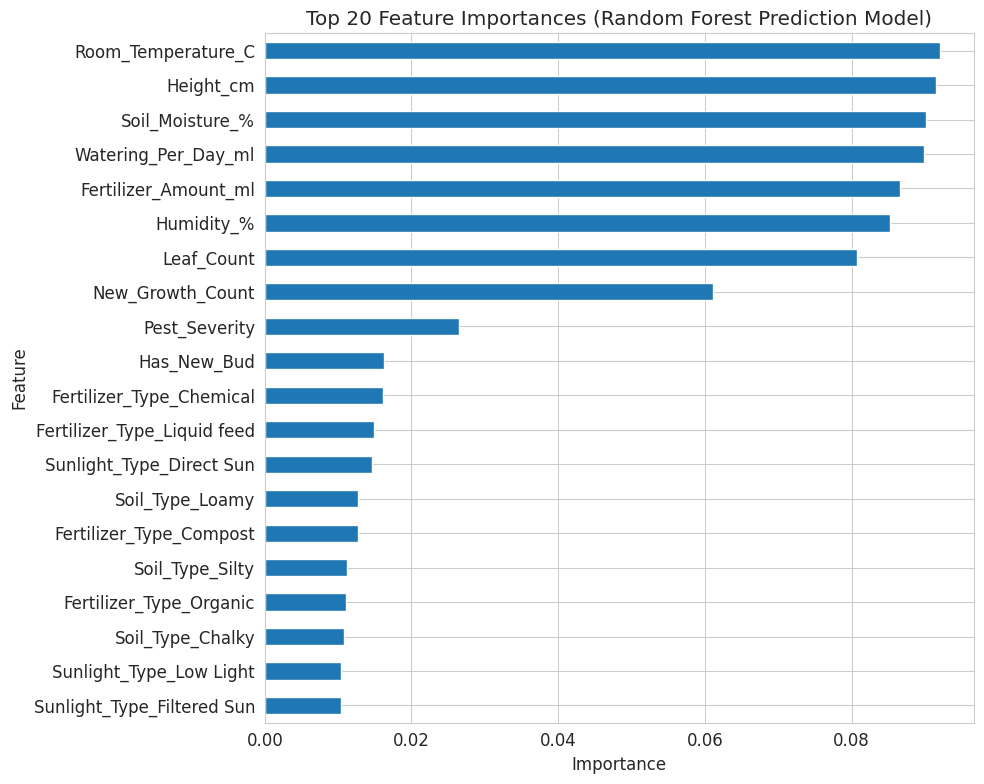


Prediction model training and evaluation complete!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For regex in feature engineering

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# --- 1. Load the Data ---
try:
    # Assuming the full dataset is named 'indoor_plant_data.csv'
    # Based on the image, the Sunlight_Exposure column is 'Sunlight_E' in the original file
    # We'll rename it for consistency with the problem description.
    # Use the correct path from previous sections
    df_predict = pd.read_csv('/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv')
    df_predict.rename(columns={'Sunlight_E': 'Sunlight_Exposure', 'Health_Nc': 'Health_Notes'}, inplace=True)
    print("Dataset loaded successfully for Prediction Model!")
    print(f"Initial shape: {df_predict.shape}")
except FileNotFoundError:
    # Improved error handling for notebook environment - print message and let cell finish
    print("Error: '/kaggle/input/indoor-plant-health-and-growth-dataset/Indoor_Plant_Health_and_Growth_Factors.csv' not found. Please ensure the CSV file is in the correct location.")
    # Avoid calling exit() which might not work as expected in all notebook environments
    # The NameError will naturally occur if df_predict wasn't assigned, stopping execution flow anyway.
    # Or you could explicitly raise an error: raise FileNotFoundError(...)
    raise # Re-raise the error after printing the message to ensure the cell stops


print("\n--- Initial Data Overview ---")
df_predict.info()
print("\n--- First 5 Rows ---")
print(df_predict.head())
print("\n--- Missing Values ---")
print(df_predict.isnull().sum())

# --- 2. Handle Missing Values (Imputation) ---
# Impute numerical NaNs with the median and categorical NaNs with the mode.
numerical_cols = df_predict.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_predict.select_dtypes(include='object').columns.tolist()

if 'Health_Score' in numerical_cols:
    numerical_cols.remove('Health_Score') # Target variable

for col in numerical_cols:
    if df_predict[col].isnull().any():
        median_val = df_predict[col].median()
        df_predict[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in numerical column '{col}' with median: {median_val}")

for col in categorical_cols:
    if df_predict[col].isnull().any():
        mode_val = df_predict[col].mode()[0]
        df_predict[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")

print("\n--- Missing Values After Imputation ---")
print(f"Total missing values: {df_predict.isnull().sum().sum()}")


# --- 3. Improved Feature Engineering for Prediction ---

# 3.1. IMPROVED: Parse Sunlight_Exposure
def parse_sunlight_exposure_improved_predict(exposure_str):
    if pd.isna(exposure_str):
        return 0.0, 'Unknown'
    exposure_str = str(exposure_str).lower()

    hours_match = re.search(r'(\d+(\.\d+)?)\s*hr[s]?', exposure_str)
    duration = float(hours_match.group(1)) if hours_match else 0.0

    if 'direct' in exposure_str or 'full sun' in exposure_str:
        sun_type = 'Direct Sun'
    elif 'morning sun' in exposure_str:
        sun_type = 'Morning Sun'
    elif 'indirect' in exposure_str:
        sun_type = 'Indirect Light'
    elif 'filtered' in exposure_str:
        sun_type = 'Filtered Sun'
    elif 'low light' in exposure_str:
        sun_type = 'Low Light'
    elif 'all day' in exposure_str and 'indirect' in exposure_str:
        sun_type = 'Indirect All Day'
    else:
        sun_type = 'Other/Unspecified'

    return duration, sun_type

df_predict['Sunlight_Duration_hrs'], df_predict['Sunlight_Type'] = zip(*df_predict['Sunlight_Exposure'].apply(parse_sunlight_exposure_improved_predict))
df_predict['Sunlight_Duration_hrs'].fillna(df_predict['Sunlight_Duration_hrs'].median(), inplace=True)


# 3.2. Watering_Per_Day_ml
df_predict['Watering_Per_Day_ml'] = df_predict['Watering_Amount_ml'] / df_predict['Watering_Frequency_days']
df_predict.replace([np.inf, -np.inf], np.nan, inplace=True)
df_predict['Watering_Per_Day_ml'].fillna(df_predict['Watering_Per_Day_ml'].median(), inplace=True)


# 3.3. Derive features from Health_Notes (important for prediction)
df_predict['Has_Yellowing'] = df_predict['Health_Notes'].str.contains('yellow', case=False, na=False).astype(int)
df_predict['Has_Wilting'] = df_predict['Health_Notes'].str.contains('wilting', case=False, na=False).astype(int)
df_predict['Has_Browning'] = df_predict['Health_Notes'].str.contains('browning', case=False, na=False).astype(int)
df_predict['Has_Strong_Stem'] = df_predict['Health_Notes'].str.contains('strong stem|strong growth', case=False, na=False).astype(int)
df_predict['Has_New_Bud'] = df_predict['Health_Notes'].str.contains('new bud|new growth', case=False, na=False).astype(int)
df_predict['Is_Brittle'] = df_predict['Health_Notes'].str.contains('brittle', case=False, na=False).astype(int)

# 3.4. Create "Is_Pest_Present" binary feature
df_predict['Is_Pest_Present'] = (df_predict['Pest_Presence'] != 'None').astype(int)

# 3.5. Drop original columns that have been engineered or are redundant
df_processed_predict = df_predict.drop(columns=[
    'Sunlight_Exposure',      # Replaced by Sunlight_Duration_hrs and Sunlight_Type
    'Watering_Amount_ml',     # Incorporated into Watering_Per_Day_ml
    'Watering_Frequency_days',# Incorporated into Watering_Per_Day_ml
    'Pest_Presence',          # Replaced by Is_Pest_Present and Pest_Severity
    'Health_Notes',           # Replaced by derived binary features
])

print("\n--- After Feature Engineering for Prediction ---")
print(df_processed_predict.head())
print(f"Processed shape: {df_processed_predict.shape}")

# --- 4. Define Features (X) and Target (y) ---
X = df_processed_predict.drop('Health_Score', axis=1)
y = df_processed_predict['Health_Score']

# Ensure y is integer type for classification
y = y.astype(int)

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) distribution:\n{y.value_counts().sort_index()}")

# --- 5. Identify Column Types for Preprocessing Pipelines ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist() # This now includes Plant_ID and Sunlight_Type

# Define Ordinal Encoder for Pest_Severity (as it has an inherent order)
ordinal_features = ['Pest_Severity']
pest_severity_order = ['None', 'Low', 'Moderate', 'High'] # Ensure this order is correct

# Remove Pest_Severity from general categorical features to handle separately
if 'Pest_Severity' in categorical_features:
    categorical_features.remove('Pest_Severity')

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features (OHE): {categorical_features}")
print(f"Ordinal features: {ordinal_features}")


# --- 6. Preprocessing Pipelines ---
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[pest_severity_order]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

print("\nData preprocessing setup complete for Prediction Model.")


# --- 7. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


# --- 8. Build the Full Pipeline (Random Forest Classifier) ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

print("\nPrediction model pipeline created.")


# --- 9. Hyperparameter Tuning using GridSearchCV ---
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nStarting GridSearchCV for hyperparameter tuning for Prediction Model...")
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\n--- GridSearchCV Results (Prediction Model) ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1-weighted score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
print("\nBest prediction model obtained from GridSearch.")


# --- 10. Model Evaluation on Test Set ---
print("\n--- Evaluating Best Prediction Model on Test Set ---")
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix (Prediction Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# --- 11. Top 20 Feature Importances (Random Forest) ---
final_rf_model = best_model.named_steps['classifier']

# Get feature names after all transformations
# Numerical features pass through directly
numerical_feature_names_out = numerical_features
# One-hot encoded features
categorical_ohe_feature_names_out = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
# Ordinal features (simply their original names)
ordinal_feature_names_out = ordinal_features

all_feature_names_transformed = list(numerical_feature_names_out) + list(categorical_ohe_feature_names_out) + list(ordinal_feature_names_out)


if len(final_rf_model.feature_importances_) == len(all_feature_names_transformed):
    feature_importances = pd.Series(final_rf_model.feature_importances_, index=all_feature_names_transformed)
    top_features = feature_importances.nlargest(20) # Display top 20 features
    print("\n--- Top 20 Feature Importances (Random Forest Prediction Model) ---")
    print(top_features)

    plt.figure(figsize=(10, 8))
    top_features.sort_values(ascending=True).plot(kind='barh')
    plt.title('Top 20 Feature Importances (Random Forest Prediction Model)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("\nWARNING: Could not perfectly match feature importances to transformed feature names.")
    print("Number of importances:", len(final_rf_model.feature_importances_))
    print("Number of combined feature names:", len(all_feature_names_transformed))
    # Fallback: Print raw importances if names don't match for inspection
    # print(final_rf_model.feature_importances_)

print("\nPrediction model training and evaluation complete!")

# --- Chapter 07: Conclusion ---

Our analysis revealed predicting universal plant health is challenging (accuracy ~0.25) due to diverse needs. However, key factors like **room temperature, soil moisture, and watering frequency** significantly influence health, as shown by feature importances.

Therefore, **clustering plants into groups with similar care patterns** offers a more practical approach. This allows for tailored care recommendations based on a plant's cluster, providing actionable insights for plant enthusiasts.